# Projet de super-résolution d'images historiques manuscrites

<b>Introduction:</b>

Notre projet vise à résoudre un problème complexe lié à la détection de texte sur des images manuscrites historiques, en particulier sur des images de basse résolution. Ces documents historiques, précieux pour leur contenu, sont souvent mal préservés et présentent des défis uniques pour la détection de texte. Pour surmonter ces obstacles, nous avons mis en place une approche innovante qui combine la super résolution d'images et l'apprentissage profond pour améliorer la qualité des images, facilitant ainsi la détection de texte.

<b>Objectif du Projet:</b>

L'objectif principal de cette phase du projet est d'exploiter des modèles de super résolution, notamment HAT (Highly Adaptive Transformer) et ESRGAN (Enhanced Super-Resolution Generative Adversarial Networks), pour augmenter la résolution d'images manuscrites historiques de basse qualité. La super résolution permettra d'améliorer la qualité des images, ce qui à son tour rendra la détection de texte plus fiable.

<b>Méthodologie</b>

<b>Préparation des Données :</b> La première étape cruciale de notre projet consiste à préparer les données.Nous avons tout d'abord créé deux ensembles d'images : les "images de référence" originales et les "images downscalées" réduites de 4 fois. Ces dernières nous permettront de calculer des mesures de performance (PSNR entre l'image de référence et l'output du moèdle) afind'évaluer l'efficacité de nos modèles de super résolution. Nous avons également introduit des techniques de data augmentation en ajoutant du bruit aux images et en effectuant des découpes pour diversifier notre ensemble de données.

<b>Sélection des Modèles Pré-Entraînés :</b> Nous avons choisi d'explorer l'utilisation de modèles de super résolution déjà pré-entraînés sur des ensembles de données tels qu'ImageNet. Ces modèles, tels que HAT et ESRGAN, ont déjà montré leur efficacité dans l'amélioration de la résolution des images. Cependant, leur application à des images manuscrites historiques est un défi distinct en raison de la nature unique de ces images.

<b>Fine-Tuning des Modèles :</b> Pour adapter les modèles à notre problème spécifique, nous avons entrepris une étape de fine-tuning. Nous avons utilisé nos propres images d'apprentissage de haute qualité pour entraîner ces modèles pré-entraînés. Le fine-tuning est essentiel pour les adapter aux caractéristiques particulières des images historiques, ce qui devrait améliorer significativement leurs performances.

<b>Évaluation des Performances :</b> Nous évaluerons les performances des modèles de super résolution après le fine-tuning en utilisant des mesures telles que la PSNR (Peak Signal-to-Noise Ratio) et la SSIM (Structural Similarity Index). Ces métriques nous aideront à quantifier l'amélioration de la qualité des images obtenue grâce à la super résolution.

## Suppression du dossier HAT si existant déjà

In [ ]:
import shutil
# Supprimez le dossier avec tous ses fichiers
shutil.rmtree('/content/HAT/datasets/Set5/GTmod4')
shutil.rmtree('/content/HAT/')

## Cloner le repertoire GIT où se trouve HAT

In [ ]:
!git clone https://github.com/XPixelGroup/HAT
%cd HAT
!mkdir /content/HAT/datasets/Set5
!mkdir /content/HAT/datasets/Set5/GTmod4
!mkdir /content/HAT/datasets/Set5/LRbicx4

Cloning into 'HAT'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 410 (delta 196), reused 155 (delta 122), pack-reused 159
Receiving objects: 100% (410/410), 20.73 MiB | 38.17 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/HAT


## Installation des pré-requis nécéssaires

In [ ]:
!pip install -r requirements.txt
!python setup.py develop

## Connexion à notre compte google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Préparation

## Importation des images



In [ ]:
import os
import shutil

def read_images(images_folder_path, destination_path):
  os.makedirs(train_folder, exist_ok=True)
  # Copiez toutes les photos du dossier Google Drive vers Colab
  for image in os.listdir(images_folder_path):
      image_path = os.path.join(images_folder_path, image)
      if os.path.isfile(image_path):
          shutil.copy(image_path, destination_path)
  return

## Exemple d'images

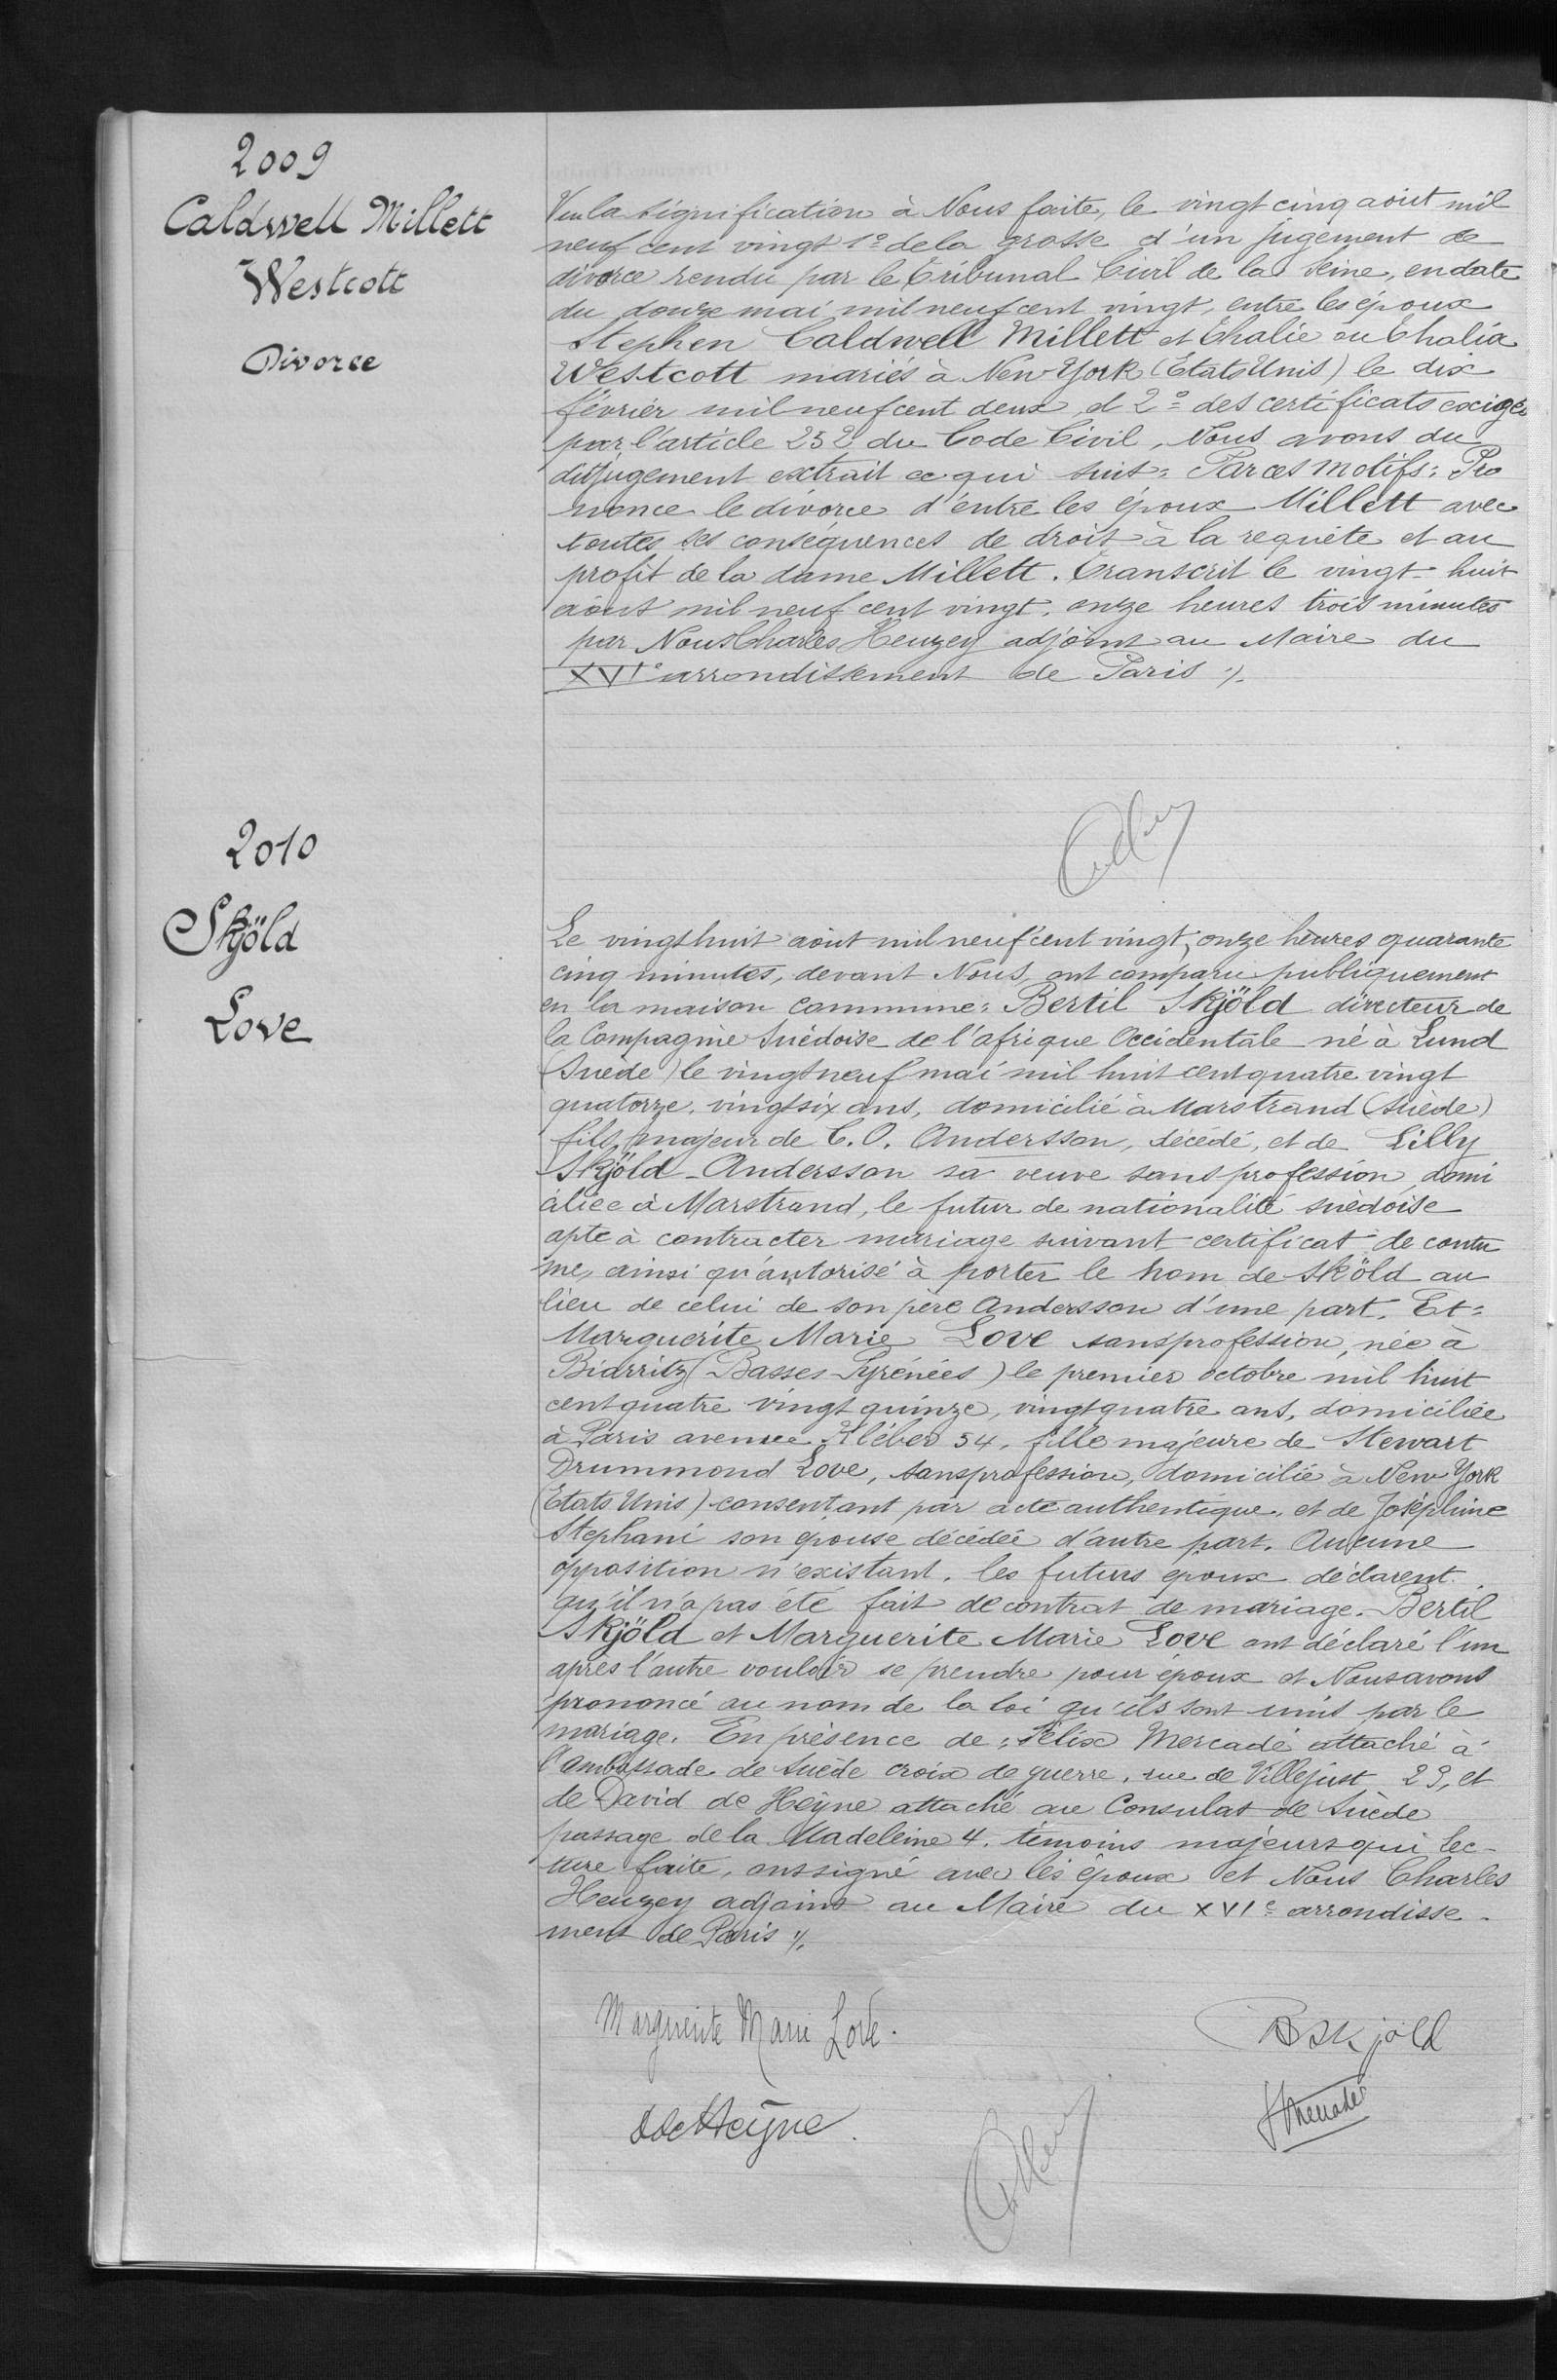

In [34]:
from IPython.display import Image
Image(filename='./examples/image_example.png',width=550, height=800)

#### Images de training

In [ ]:
read_images('/content/drive/MyDrive/data/train/', '/content/HAT/train_data')

#### Images de validation

In [ ]:
read_images('/content/drive/MyDrive/data/valid/', '/content/HAT/valid_data')

#### Images de test

In [ ]:
read_images('/content/drive/MyDrive/data/test/', '/content/HAT/test_data')

## Création des données d'apprentissage à partir des images de références + data augmentation
Avant d'entrainer ou tester nos modèles il est important de préparer les données en effectuant les opérations suivante:

* A partir des données de réference nous allons générer des données d'apprentissage qui ont 4 fois moinds de Pixels (car nous voulons entrainer et tester des modèles de super résolution x4). Cela va permettre d'évaluer notre modèle en calculant par exemple le PSNR entre l'images upscale (en output du modèle) avec nos images de référence.
* Nous allons également procédé à l'augmentation des données en faisant multible crops (20) de taill 400x400 pixels

<b>Remarque:</b> Une autre augmentation des données à été efféctué au préalable en insérant du bruit sur l'ensemble des images (un bruit gaussien avec $\sigma=0.1$)

## Aperçu du bruit gaussien

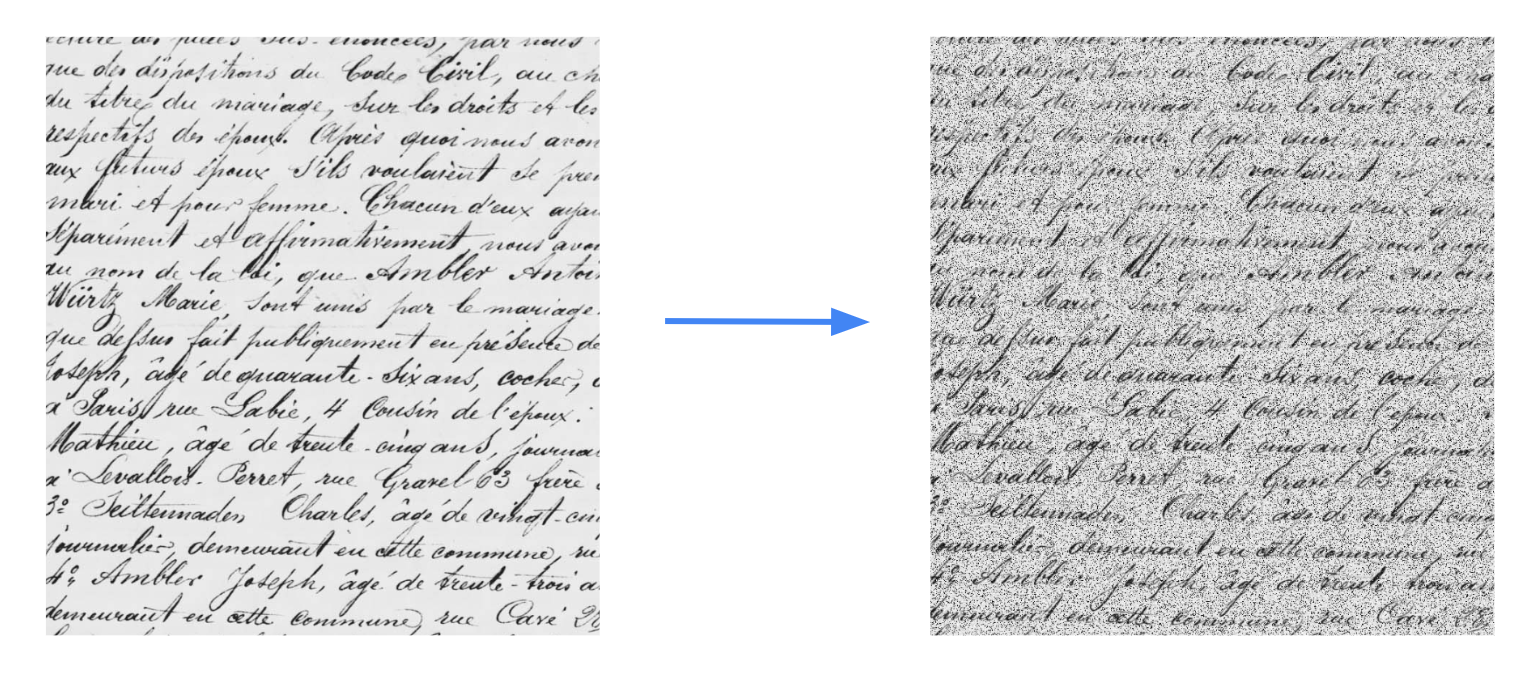

In [33]:
from IPython.display import Image
Image(filename='./examples/noise_example.png')

In [ ]:
!mkdir ./datasets/train
!mkdir ./datasets/valid
!mkdir ./datasets/test
!mkdir ./datasets/train/HR
!mkdir ./datasets/train/LR
!mkdir ./datasets/valid/HR
!mkdir ./datasets/valid/LR
!mkdir ./datasets/test/HR
!mkdir ./datasets/test/LR

In [ ]:
import cv2
import numpy as np
import random
from PIL import Image
import os

folder_reference_images = '/content/HAT/train_data'
folder_crop_reference = '/content/HAT/datasets/train/HR'
folder_crop_downscalex4 = '/content/HAT/datasets/train/LR'

def image_crops(images_location_path, destination_path, window_width, window_hight, nb_crops):
    for filename in os.listdir(images_location_path):
        with Image.open(os.path.join(images_location_path, filename)) as img:
            width, height = img.size
            it=0
            while(it<nb_crops):
                i=random.randint(0,height-window_hight)
                j=random.randint(0,width-window_width)
                box = (j,i, j + window_width, i + window_hight)
                region = img.crop(box)
                region.save(f"{destination_path}/{filename[:-4]}_{it+1}.png", "PNG")
                it+=1
    return

# Exemple d'utilisation :
image_crops(folder_reference_images, folder_crop_reference, 400, 400, 20)

In [ ]:
def downscale(images_location_path, destination_path, ds_ratio = 4):
    for filename in os.listdir(images_location_path):
        with Image.open(os.path.join(images_location_path, filename)) as img:
            width, height = img.size
            col_width = width // ds_ratio
            row_height = height // ds_ratio
            image=img.resize((col_width,row_height))
            image.save(f"{destination_path}/{filename[:-4]}.png", "PNG")
    return
# Exemple d'utilisation :
downscale(folder_crop_reference, folder_crop_downscalex4, 4)

#### Downscale x4 des images de référence + data augmentation (images de validation)

In [ ]:
image_crops('/content/HAT/valid_data', '/content/HAT/datasets/valid/HR', 400, 400, 20)
downscale('/content/HAT/datasets/valid/HR', '/content/HAT/datasets/valid/LR', 4)

#### Downscale x4 des images de référence + data augmentation (images de test)

In [ ]:
image_crops('/content/HAT/test_data', '/content/HAT/datasets/test/HR', 400, 400,20)
downscale('/content/HAT/datasets/test/HR', '/content/HAT/datasets/test/LR', 4)

## Importation des modèles pré-entrainés

Les modèle pretrained sont disponibles sur le [liens Git](https://github.com/XPixelGroup/HAT) des auteurs ou vous pouvez directement les télécharger sur leurs [liens google drive](https://drive.google.com/drive/folders/1HpmReFfoUqUbnAOQ7rvOeNU3uf_m69w0)

In [ ]:
import os
import shutil

pretrained_models_path = '/content/drive/MyDrive/pretrained_models/'

# Créez un nouveau dossier dans Colab
destination_folder = '/content/HAT/experiments/pretrained_models'
os.makedirs(destination_folder, exist_ok=True)

# Copiez tout les modèless de Google Drive vers Colab
for fichier in os.listdir(pretrained_models_path):
    model_path = os.path.join(pretrained_models_path, fichier)
    if os.path.isfile(model_path):
        shutil.copy(model_path, destination_folder)

# Tester les modèles de super-résolution

## Test avec le modéle pré-entraîné

Les modèles proposé sont pré-entrainé sur la base ImageNet

Il est possible de tester plusieurs modèle en en fonction du fichier .yml utilisé e.g. 'Real_HAT_GAN_SRx4.yml' ou 'HAT_SRx4.yml'

In [ ]:
!python hat/test.py -opt /content/HAT/options/test/HAT_SRx4.yml

Disable distributed.
Path already exists. Rename it to /content/HAT/results/HAT_SRx4_archived_20230414_215604
2023-04-14 21:56:04,769 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.3.4.9
	PyTorch: 2.0.0+cu118
	TorchVision: 0.15.1+cu118
2023-04-14 21:56:04,769 INFO: 
  name: HAT_SRx4
  model_type: HATModel
  scale: 4
  num_gpu: 1
  manual_seed: 0
  datasets:[
    test_1:[
      name: Set5
      type

## Fine-Tuning du modèle

In [ ]:
!python hat/train.py -opt /content/HAT/options/train/train_HAT_SRx4_finetune_from_ImageNet_pretrain.yml

Disable distributed.
2023-04-15 12:43:19,904 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.3.4.9
	PyTorch: 2.0.0+cu118
	TorchVision: 0.15.1+cu118
2023-04-15 12:43:19,904 INFO: 
  name: train_HAT_SRx4_finetune_from_ImageNet_pretrain
  model_type: HATModel
  scale: 4
  num_gpu: 1
  manual_seed: 0
  datasets:[
    train:[
      name: DF2K
      type: PairedImageDataset
      dataroot_gt: /content/HAT

## Test du modèle Fine-Tuned

In [ ]:
!python hat/test.py -opt /content/HAT/options/test/HAT_SRx4.yml

Disable distributed.
2023-04-15 02:43:38,791 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.3.4.9
	PyTorch: 2.0.0+cu118
	TorchVision: 0.15.1+cu118
2023-04-15 02:43:38,792 INFO: 
  name: HAT_SRx4
  model_type: HATModel
  scale: 4
  num_gpu: 1
  manual_seed: 0
  datasets:[
    test_1:[
      name: Set5
      type: PairedImageDataset
      dataroot_gt: /content/HAT/datasets/test/HR
      dataroot_lq: 

# Résultats

## Exemple de reconstruction d'images

Image de référence

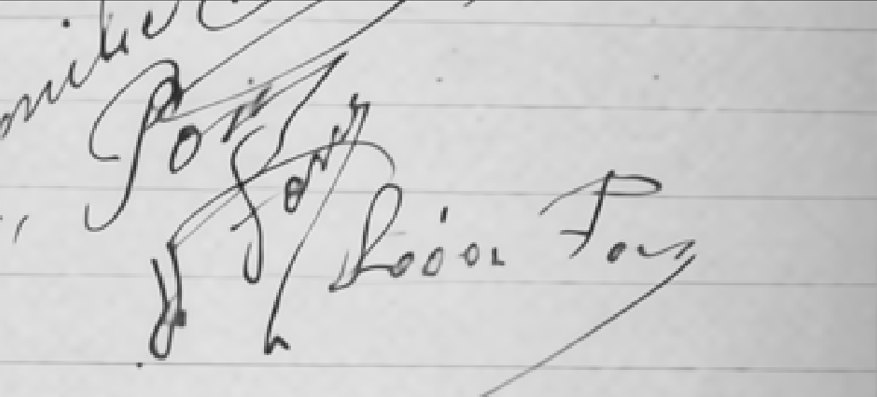

In [19]:
from IPython.display import Image
Image(filename='./examples/reference_image.png',width=500, height=300)

Image Downscale

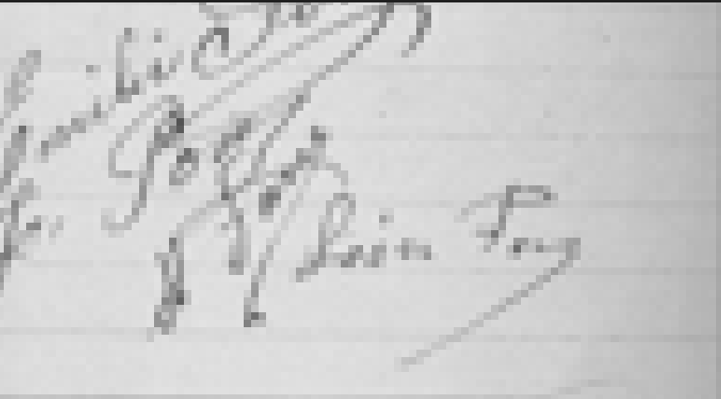

In [21]:
from IPython.display import Image
Image(filename='./examples/downscale_image.png',width=500, height=300)

Reconstructed Image

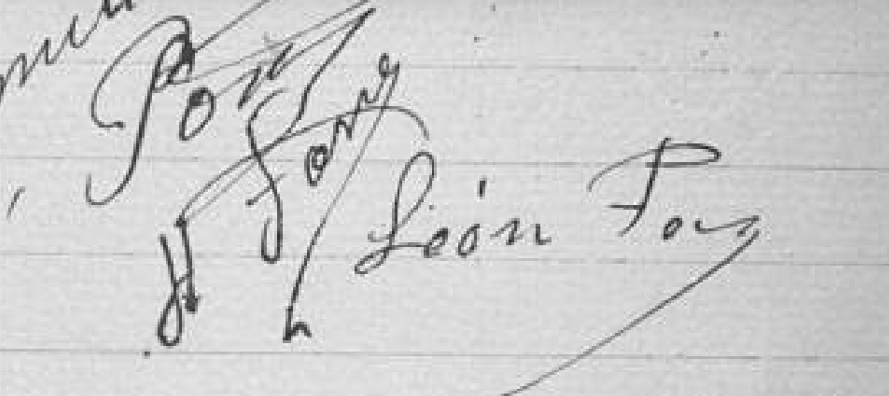

In [22]:
from IPython.display import Image
Image(filename='./examples/reconstructed_image.png',width=500, height=300)

Le modèle HAT: Hybrid Attention Transformer for Image Restoration est de loin le meilleur modèle pour la super résolution avec un PSNR = 32.2 est SSIM = 0.9. Les résultats des expérientation se trouve dans la figure ci-dessous

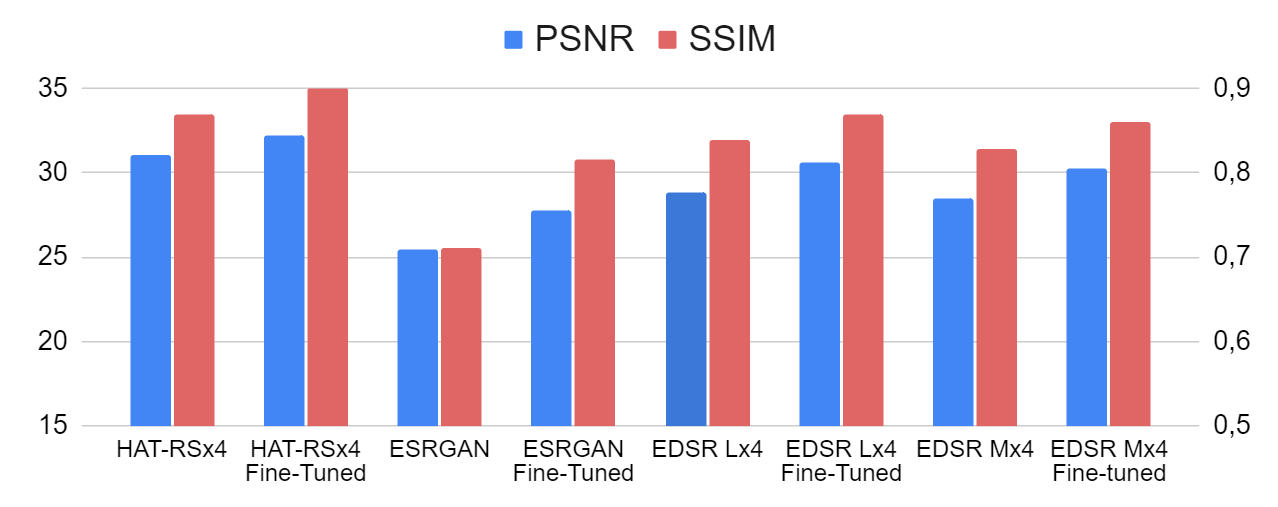

In [10]:
from IPython.display import Image
Image(filename='results.png')